# Assignment #2 - Classification

<font color="red"> <b> Due: Oct 11 (Thursday) 11:00 pm </b> </font>

<font color="blue"> Benjamin Daniel Poole </font>

# I. Introduction

Describe the objective of this assignment. You can briefly state how you accompilsh it.

# II. Data

Introduce your data and visualize them. Describe your observations about the data.
You can reuse the data that you examined in Assignment #0 (of course for classification). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Preprocessing

My preprocessing will consist of refining my data into window sizes. When looking at EEG data we must break the data into groups since looking at each indivdual data sample tells us nothing. It was found in the paper that the ErrP signal occurs around .2s-.9s after the errorenous event. Here, my window will be around 358 samples or .7s this is about the same size of the length of an ErrP (these numbers are based on what the paper authors used),.

In [59]:
# Preprocessing Functions 
"""
Reduces target from 1s to desired window by changing target value

y         Target data, array of trials
locs      Location of ErrP
window    Start and end locations of window that's target should not be changed    
target    New Target value  
"""
def reduce_tar(y, errp_locs, window, target=0):
    for i in range(len(errp_locs)): # index each ErrP
        #print(len(errp_locs[i]), window[1])
        win_start = errp_locs[i][window[0]]
        win_end = errp_locs[i][window[1]]
        y[errp_locs[i][0]:win_start] = target # set target to NoErrP
        y[win_end:errp_locs[i][-1]+1] = target # set target to NoErrP

        '''
Groups consecuative numbers together (e.g. 1,2,3,4)

data        data to be grouped
'''
def group_consec(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
            
"""
Checks to make sure all ErrPs are of valid size

errp_locs   Locations of ErrPs
smp_rate    Sampling rate of EEG data (samples recorded per second) 
"""
def check_size(errp_locs, smp_rate):
    for i in errp_locs:
        if len(i) < smp_rate:
            print("Size too small", i[0] ,len(i))

"""
Extracts data that corresponds to a certain target value

x           Data you are indexing
y_loc       Location of target value (index)
offset      Offsets your data extraction (- to move index backwards, + to move index forward)
"""
def extract_data(x, y_loc, offset=0):
    errp_data = []
    for i in range(0, len(y_loc)):
        errp_data.append(x[y_loc[i]+offset, :])
    return errp_data

            


In [101]:
# Data Loading
from scipy.io import loadmat
cols = ["Fpz", "AFz", "F3", "Fz", "F4", "F8", "FC3", "FCz", "FC4", "T7", "C3", "Cz", "C4", "T8", "CP3", "CPz", "CP4", "P7", "P3", "Pz", "P4", "P8", "PO7", "POz", "PO8", "O1", "Oz", "O2"]
win_size = 358 # .2s-.9s or .7s long in terms of samples

#############################################################################
# Data Loading
train_df = loadmat("class_train.mat") # load test data
train_data = train_df["eeg_signal"][:, :28] # extract train data
train_target = train_df["marker"][0][0][1] # extract train targets
train_onehop = pd.get_dummies(train_df["marker"][0][0][1].reshape(-1)) # extract train targets as a one-hot

eeg_df= pd.DataFrame(df_conf["eeg_signal"][:, :28]) # extract train data as dataframe for display use
eeg_df.set_axis(cols,axis=1) # add headers to dataframe

test_df = loadmat("class_test.mat") # load test data
test_data = test_df["eeg_signal"][:, :28] # extract test data
test_target = test_df["marker"][0][0][1] # extract test targets
test_onehop = pd.get_dummies(test_df["marker"][0][0][1].reshape(-1)) # extracty test targets as a one-hot

#############################################################################
# Target Reducing 
train_locs = group_consec(np.where(train_target == 1)[0]) # Find all train ErrPs (target=1)
test_locs = group_consec(np.where(test_target == 1)[0]) # Find all test ErrPs (target=1)
print("ErrP loc size before reduction:", len(train_locs), len(test_locs))

# Paper used time range .2s-.9s, this as length of ErrP signals (358 samples long = 1 ErrP)
start = int(.2 * 512)
end = int(.9 * 512)
reduce_tar(train_target, train_locs, window=[start, end]) # reduce targets marked as ErrP to .2s-.9s window size (358 samples)
reduce_tar(test_target, test_locs, window=[start, end]) # reduce targets marked as ErrP to .2s-.9s window size (358 samples)

train_locs = group_consec(np.where(train_target == 1)[0]) # Find all train ErrPs (target=1)
test_locs = group_consec(np.where(test_target == 1)[0]) # Find all test ErrPs (target=1)
check_size(train_locs, win_size) # check to make sure sizes indivual ErrP sizes are 358 are correct
check_size(test_locs, win_size) # check to make sure sizes are correct
print("ErrP loc size after reduction:", len(train_locs), len(test_locs)) # after lengths should match before lengths

#############################################################################
# Extract Data and Undersample Data
# Extract Data for Train
train_errp = extract_data(train_data, train_locs) # extracts data that corresponds to ErrPs
train_not_errp = extract_data(train_data, train_locs, -win_size) # extracts data that corresponds to non-ErrPs that occurs right before each ErrP (This will be our negative class)
if np.sum(np.vstack(train_errp) == np.vstack(train_not_errp)) != 0: # make sure no data overlaps (No ErrP samples in non-ErrP signals and vic-versa)
    print("DATA OVERLAP WARNING!")
train_data_us= train_errp + train_not_errp # combine ErrP and Non-ErrP data for training
train_target_us = np.ones((len(train_eeg_data), 1)) # create target for train data
half = int(len(train_target_us)/2) # get half way point
train_target_us[:half] = -1 # set first half of target to 1 (to match with ErrP data)
train_onehot_us = np.zeros((len(train_eeg_data), 2))
train_onehot_us[:half, :] = [0,1] # set first half of target to 0,1 (to match with ErrP data)
train_onehot_us[half:] = [1,0] # set second half of target to 1,0 (to match with Non-ErrP data)
print("Train ErrP + Non-ErrP length:",len(train_eeg_data))

# Extract Data for Test
test_errp = extract_data(test_data, test_locs) # extracts data that corresponds to ErrPs
test_not_errp = extract_data(test_data, test_locs, -win_size) # extracts data that corresponds to non-ErrPs that occurs right before each ErrP (This will be our negative class)
if np.sum(np.vstack(test_errp) == np.vstack(test_not_errp)) != 0: # make sure no data overlaps (No ErrP samples in non-ErrP signals and vic-versa)
    print("DATA OVERLAP WARNING!")
test_eeg_data = test_errp + test_not_errp
print("Test ErrP + Non-ErrP length:", len(test_eeg_data))
test_data_us= test_errp + test_not_errp # combine ErrP and Non-ErrP data for testing
test_target_us = np.ones((len(test_eeg_data), 1)) # create target for train data
half = int(len(test_target_us)/2) # get half way point
test_target_us[:half] = -1 # set first half of target to 1 (to match with ErrP data)
test_onehot_us = np.zeros((len(test_eeg_data), 2))
test_onehot_us[:half, :] = [0,1] # set first half of target to 0,1 (to match with ErrP data)
test_onehot_us[half:] = [1,0] # set second half of target to 1,0 (to match with Non-ErrP data)

C:\Users\Loyal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


ErrP loc size before reduction: 125 63
ErrP loc size after reduction: 125 63
Train ErrP + Non-ErrP length: 250
Test ErrP + Non-ErrP length: 126


### Visualization

#### Ground Truth (Classes)

As you can see here the class distribution is extremely imbalanced. There are far more no error instances then there are error instances. It will be interesting to see if the positive class (error) can be efficiently identified with such imbalance.

In [26]:
err = group_consec(np.where(train_target == 1)[0]) # extract error locations
no_err = np.where(train_target == 0)[0] # extract no error location
y = [len(no_err)/358, len(err)]
x = np.arange(2)

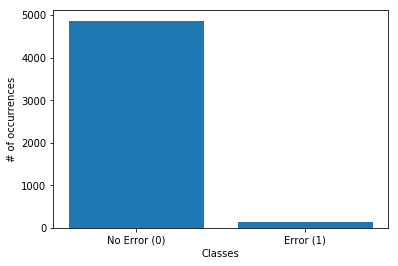

In [27]:
plt.bar(x,y)
plt.xticks(x, ("No Error (0)", "Error (1)"))
plt.ylabel("# of occurrences")
plt.xlabel("Classes")
plt.show()

#### Features

**First 1 Minutes of Data**: Here we can observer some of the important channels and their Hz fluctuation over the first minute during the 60 minutes recorded data. These important channels are determined by their proximity to where the error signal is elicited in the brain (the signal is elicited near the frontal-center region of the head or the front cortex region). We can also observer large spikes in the Hz values throughout the minute of testing indicating noise interference. Displaying this much EEG data is not very helpful though.

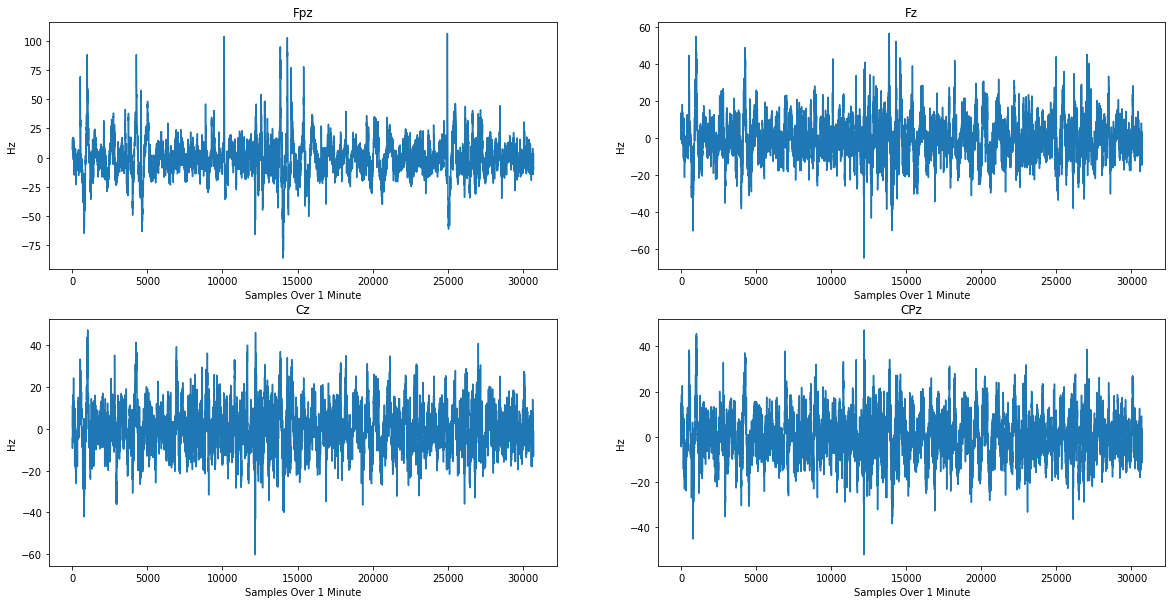

In [29]:
ch = ['Fpz','Fz','Cz', 'CPz'] 
ax = []
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax =  ax.flatten()
time = 60 * 512 # 60 seconds * sample rate (smaples per second)

for i in range(len(ax)):
    ax[i].plot(eeg_df.loc[:time,ch[i]])
    ax[i].set_title(ch[i])
    ax[i].set_xlabel("Samples Over 1 Minute")
    ax[i].set_ylabel("Hz")

TODO: FIX OBSERVATIONS DATA SWITCH

**First Second of Data** Here it is much easier to observer what is happening in the brain, due to the smaller time window. To some degree we can make out a common pattern among all the different channels with the Fz electrode clearing defining the pattern and the Fpz channel closely following suit. We can see on all channels that there is a spike around the 450th sample (.87s).

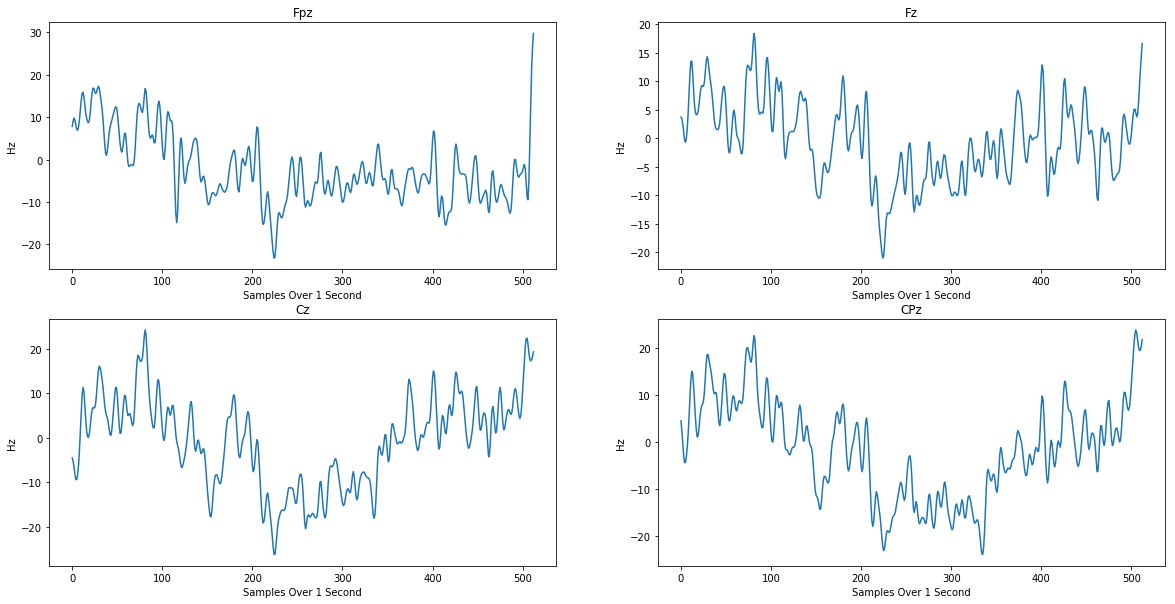

In [30]:
ax = []
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax =  ax.flatten()
time = 1 * 512 # seconds * sample rate (smaples per second)

for i in range(len(ax)):
    ax[i].plot(eeg_df.loc[:time,ch[i]])
    ax[i].set_title(ch[i])
    ax[i].set_xlabel("Samples Over 1 Second")
    ax[i].set_ylabel("Hz")

**First Second of Data For All Channels** : As you can see here as the electrodes move further away from each other the signal patterns differentiate. For instance, take graph 1 (FPz) and graph 28 (O2). The FPz electrode is located near the forehead while the O2 is located on the back of the head and their signal patterns are quite distinct.

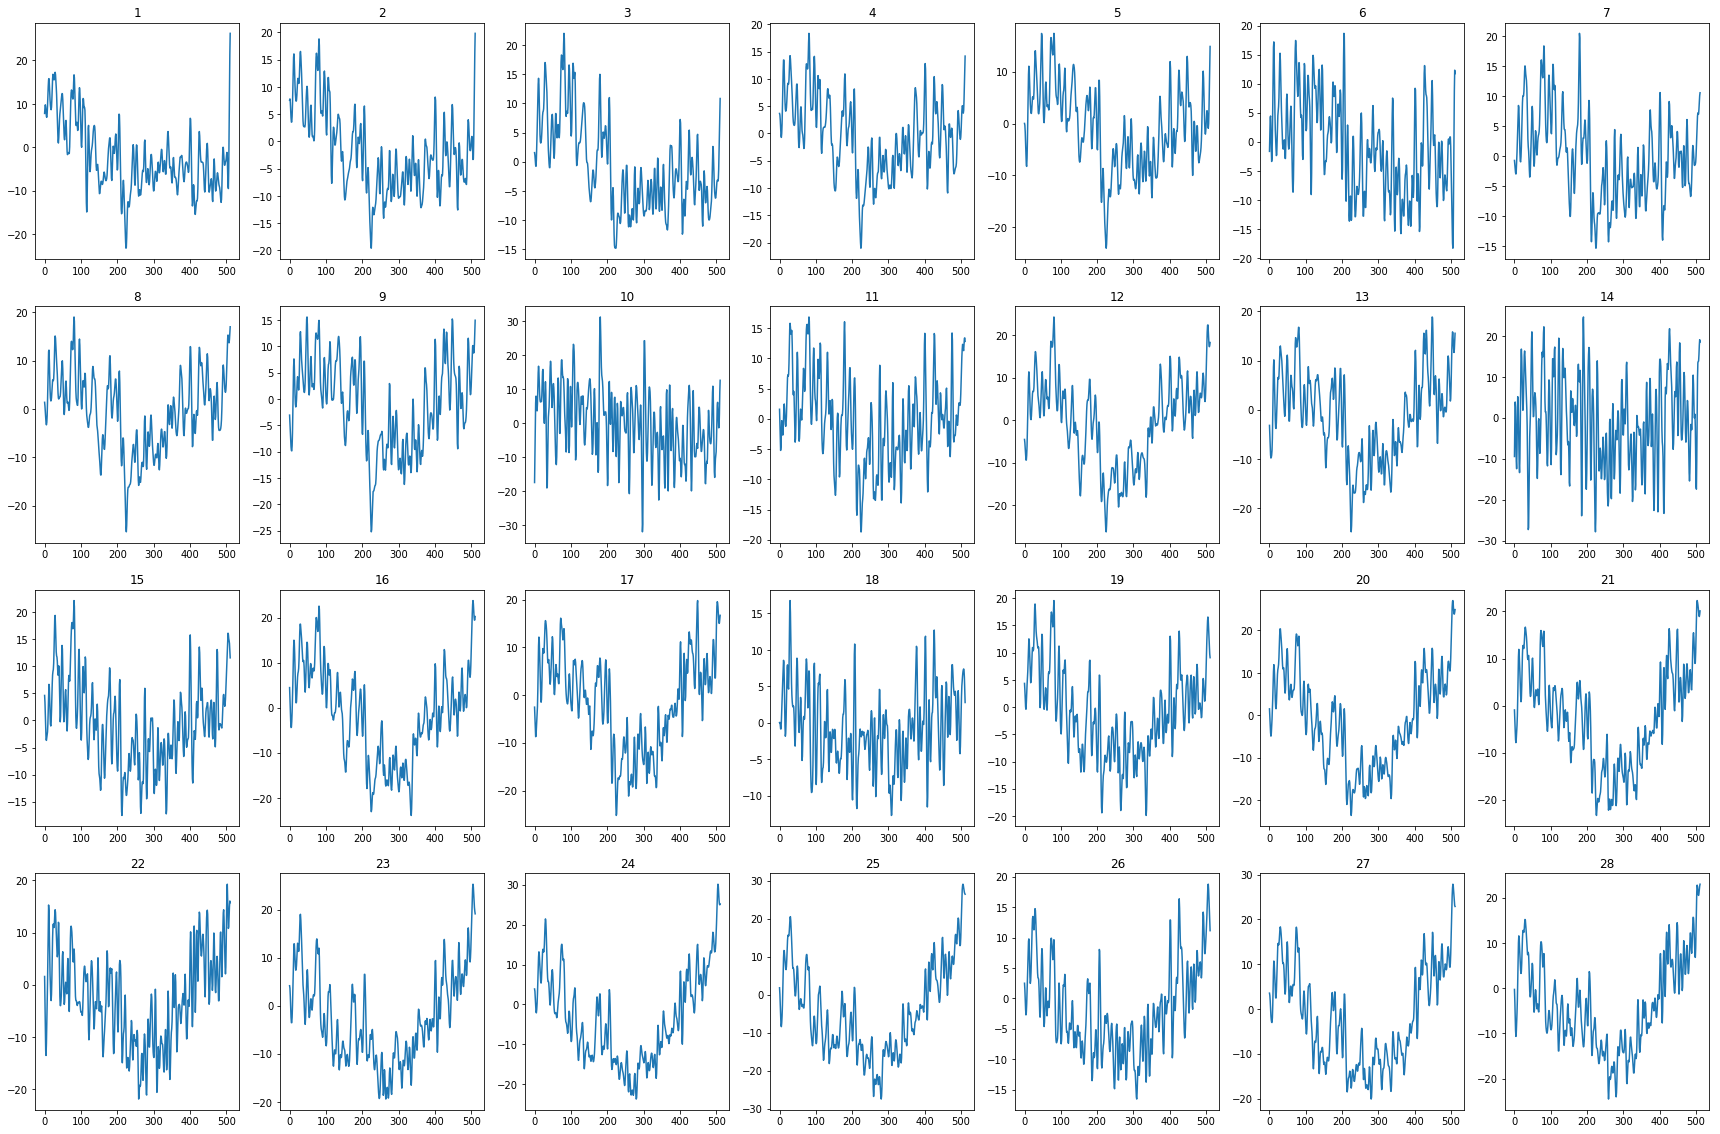

In [31]:
ax = []
fig, ax = plt.subplots(4,7, figsize=(30,20))
ax =  ax.flatten()
time = 1 * 512 # seconds * sample rate (smaples per second)

for i in range(len(ax)):
    ax[i].plot(eeg_df.iloc[:time,i])
    ax[i].set_title(i+1)

# III. Method

Summarize the pocket algorithm, discriminant analysis, and logistic regression.
The superclass *Classifier* defines common utility methods. 
Finish the normalize function for you. 
Do not forget explain your implementation. 

The explanation of your codes should not be the comments in a code cell. 
This section should include
 - review of the 4 classification models 
 - your implementation and description


### A. Super Classs Definition

In [93]:
import numpy as np
import abc

# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    

class Classifier(BaseModel):
    """
        Abstract class for classification 
        
        Attributes
        ==========
        meanX       ndarray
                    mean of inputs (from standardization)
        stdX        ndarray
                    standard deviation of inputs (standardization)
    """

    def __init__(self, ):
        self.meanX = None
        self.stdX = None

    def normalize(self, X):
        """ standardize the input X """
        
        if not isinstance(X, np.ndarray):
            X = np.asanyarray(X)

        self.meanX = np.mean(X, 0)
        self.stdX = np.std(X, 0)

        # TODO: Finish this normalization
        Xs = (X - self.meanX) / self.stdX
        return Xs

    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abc.abstractmethod
    def train(self, X, T):
        pass
    
    @abc.abstractmethod
    def use(self, X):
        pass 

In [94]:
mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

C1 = np.random.multivariate_normal(mu1, cov1, 50)
C2 = np.random.multivariate_normal(mu2, cov2, 50)

X = np.vstack((C1, C2))
N = X.shape[0]
T = np.ones(N, dtype=int).reshape(-1,1)
T[:50] *= 0

T_ind = np.zeros((len(T), 2))
T_ind = np.eye(2)[T.reshape(-1)]

### B. Pocket Algorithm


In [108]:
from copy import deepcopy as copy 

class Pocket(Classifier):

    def compare(self, X, T):
        y = np.sign(X @ self.w) # MxN @ N,= M,
        yp = np.sign(X @ self.w_pocket) # MxN @ N,= M,

        return 1 if np.sum(y == T) >= np.sum(yp == T) else -1

    def train(self, X, T, alpha=.1, maxiter=1000):
        self.w = np.random.rand(X.shape[1]) # N,
        self.w_pocket = copy(self.w) # N,
        
        for _iter in range(maxiter):
            converged = True
            for i in np.random.permutation(len(X)): # randomly select samples TODO: Change if need be for data
                y = self.w @ X[i] # N, @ N, = scalar 
                if np.sign(y) != np.sign(T[i]):
                    self.w += alpha * T[i] * X[i] # 1, * N, = N,
                    converged = False
                    if self.compare(X, T) > 0:
                        self.w_pocket[:] = self.w[:]
            if converged:
                print("Converged at:", _iter)
                break
        print("End of training: ", _iter)
            
    def use(self, X):
        Y = X @ self.w_pocket # MxN @ N,= M

        return Y

In [109]:
pocket = Pocket()
pocket.train(train_data_us, train_target_us)

ValueError: shapes (28,) and (358,28) not aligned: 28 (dim 0) != 358 (dim 0)

End of training:  999
(100, 1)


array([], dtype=int64)

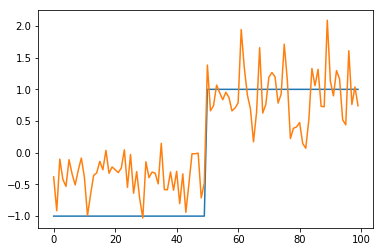

In [141]:
pocket = Pocket()
pocket.train(X, T)
Y = pocket.use(X).reshape(-1,1)
print(Y.shape)
plt.plot(T)
plt.plot(Y)


In [216]:
truth = (T == 1).reshape(-1)
len(X[truth])

50

### C. QDA

In [133]:
class QDA(Classifier):
    def __init__(self):
        self.mu = [] # init list for each class
        self.sig = [] # init list for each class
        self.prior = [] # init list for each class
    
    
    def discrim(self, X, mu, sig, prior):
        sig_inv = np.linalg.inv(sig)
        det_sig = np.linalg.det(sig)
        diff = X - mu
        sum_diff = np.sum(diff @ sig_inv * diff, axis=1)
        
        qda = -.5 * np.log(det_sig) - .5 * sum_diff + np.log(prior)
        
        return qda
    
    def train(self, X, T):
        self.classes = np.unique(T)
        for i in self.classes: # get unqiue classes
            truth = (T == i).reshape(-1)
            self.mu.append(np.mean(X[truth], 0)) # compute mean for each feature
            self.sig.append(np.cov(X[truth].T)) # compute covariance matrix
            self.prior.append(len(X[truth]) / len(X)) # compute prior (# of samples per class / total samples)
            
    def use(self, X):
        qda = []
        for i in range(len(self.classes)): # apply qda to each classes metrics
            qda.append(self.discrim(X, self.mu[i], self.sig[i], self.prior[i]))
        Y = np.argmax(qda, 0) # take max (column wise) to determine which class qda predicted
        return  Y 

In [134]:
np.array(train_data_us)[0].shape

(358, 28)

In [137]:
qda = QDA()
train = np.array(train_data_us)
qda.train(train, train_target_us)
Y = qda.use(train)
Y.shape

(250, 28)

In [115]:
qda = QDA()
qda.train(X, T)
Y = qda.use(X)
Y



[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### D. LDA

In [232]:
class LDA(Classifier):
    
    def __init__(self):
        self.mu = [] # init list for each class
        self.sig = None # init fixed sigma
        self.prior = [] # init list for each class
    
    
    def discrim(self, X, mu, sig, prior):
        sig_inv = np.linalg.inv(sig)
        dot_X = np.dot(X, sig_inv)
        dot_mu = np.dot(mu, sig_inv)
        lda = np.sum(dot_X * mu - .5 * dot_mu * mu + np.log(prior), axis=1)
        
        return lda
    
    def train(self, X, T):
        self.classes = np.unique(T)
        self.sig = np.cov(X.T) # compute fixed covariance
        for i in self.classes: # get unqiue classes
            truth = (T == i).reshape(-1)
            self.mu.append(np.mean(X[truth], 0)) # compute mean for each feature
            self.prior.append(len(X[truth]) / len(X)) # compute prior (# of samples per class / total samples)
            
    def use(self, X):
        lda = []
        for i in range(len(self.classes)): # apply qda to each classes metrics
            lda.append(self.discrim(X, self.mu[i], self.sig, self.prior[i]))
        Y = np.argmax(lda, 0) # take max (column wise) to determine which class qda predicted
        return  Y 

In [233]:
lda = LDA()
lda.train(X, T)
Y = lda.use(X)
Y


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### E. Logistic Regression

In [303]:
class Logistic_Reg(Classifier):
    
    def softmax(self, X):
        z = X @ self.w 
        if not isinstance(z, np.ndarray):
            z = np.asarray(z)
        f = np.exp(z) 
        return f / (np.sum(f, axis=1, keepdims=True) if len(z.shape) == 2 else np.sum(f))
    
    def train(self, X, T, alpha=.1, maxiter=1000): # Needs indicator variable
        X1 = self.add_ones(X)
        self.w = np.zeros((X1.shape[1], T.shape[1])) # D+1xK (D+1 = M)
        for i in range(maxiter):
            ys = self.softmax(X1)
            self.w += alpha * X1.T @ (T - ys) # MxN @ Nx2 = Mx2
            
    def use(self, X):
        X1 = self.add_ones(X)
        Y_raw = self.softmax(X1)
        Y = np.argmax(Y_raw, 1)
        return Y
        
        

In [304]:
log = Logistic_Reg()
log.train(X, T_ind)
Y = log.use(X)
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# IV. Experiments

Apply the classfiers on the data and discuss the results.
Please describe your codes for experiments. You may have subsections of results and discussions here.
Here follows the list that you consider to include:
- the classification results
- plots of classification results 
- model comparision 
- choice of evaluation metrics
- **Must partition data into training and testing**

# Conclusions

Summarize your work here. 
Which classifier do you think the best? 
Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

# References

List all your references here.

# Extra Credit

* [OPT 1] Search for a ordinal data set and apply your classifiers to it. 
  - Repeat the experiments on it. 
  - Do you have different observation from previous results? 
  - Were you able to observe that we discussed in class about logistic regression? 
  - For a full extra credit point, you need to discuss all bullet points in Results section.     


* [OPT 2] Partition your data into five sets. Selecting one test set and the other for training, repeat your experiments and observe/analyze the 5 different training/testing errors.  

## Grading

DO NOT forget to submit your data! Your notebook is supposed to run well after running your codes.

To help our TA's grading, please make an explicit section for each grading criteria. 
Again, this is a **writing assignment**. Please don't forget to properly explain your codes and results using Markdown cell. 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
15 | Data | 
 | 5| description 
 | 5| plots for understanding or analysis 
 | 5| preliminary observation 
25 | Methods | 
 |10| Summary of Classification models
 | 5| Explanation of codes
 |10| Pocket, LDA, QDA, Logistic Regression
40 | Experiments 
| 5| Discussion about evaluation metrics
| 5| Discussion about train and test accuracies
|20| plots for results (5 for each algorithm)
|10| Discussions about classificaion model comparison
5 | |Conclusions 
5 | |Referemces
5 | |Grammar and spelling error (Proofread please)